In [51]:
INPUT_DIRECTORY = "../dataset"
OUTPUT_DIRECTORY = "../output"
MODEL_DIRECTORY = "../model"
CREDENTIALS_DIRECTORY = "../config"

In [52]:
import os
import base64
import requests
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding,Flatten
from keras.layers import LSTM,SimpleRNN,GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,CSVLogger
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,classification_report


In [53]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = f"{name}-{tv}"
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"


# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

    
# Helper functions
def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(filename):
    print()
    print("Analyzing: {}".format(filename))
    df = pd.read_csv(filename,encoding=ENCODING)
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>2000:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

def analyze_df(dataframe):
    df = dataframe
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>2000:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

            
# Function to plot Confusion Matrix (to be used later).
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [54]:
filename = "finaldata.csv"
file = os.path.join(INPUT_DIRECTORY,filename)
df = pd.read_csv(file)
df.head()


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,SubLabel
0,52.37.91.227,443,10.100.56.120,57406,6,24/06/2019 01:02:13 PM,292,0,4,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,Normal
1,52.37.91.227,443,10.100.56.120,57406,6,24/06/2019 01:02:13 PM,13,1,1,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,Normal
2,34.247.142.70,443,10.100.56.120,60682,6,24/06/2019 01:02:14 PM,538,0,4,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,Normal
3,34.247.142.70,443,10.100.56.120,60682,6,24/06/2019 01:02:14 PM,36,1,1,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,Normal
4,54.246.195.82,443,10.100.56.120,59700,6,24/06/2019 01:02:15 PM,430,0,4,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,Normal


In [55]:
drop_columns = ['Timestamp','Src IP','Dst IP','Src Port','Dst Port','SubLabel']

In [56]:
df.drop(drop_columns,inplace=True,axis=1)

In [57]:
range(len(df.columns))


range(0, 78)

In [58]:
encode_text_dummy(df, 'Protocol')


df.loc[df['Label']=='Normal', 'Label'] = 0
df.loc[df['Label']=='Threat', 'Label'] = 1

In [59]:
 df['Flow Byts/s'] = df['Flow Byts/s'].astype('float32')
 df['Flow Pkts/s'] = df['Flow Pkts/s'].astype('float32')

In [60]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()


In [61]:
range(len(df.columns))

range(0, 80)

In [62]:
data = df.values
x, y = to_xy(df,'Label')
#  Use StandardScaler() to scale the dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [63]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(x, y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(62989, 79) (13498, 79) (13498, 79) (62989, 2) (13498, 2) (13498, 2)


In [64]:

print("#### Dense Neural Network ####")

model = Sequential()
model.add(Dense(54, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
history = model.fit(X_train,Y_train,validation_data=(X_val, Y_val),callbacks=[monitor],verbose=2,epochs=1000)
model.save("model.h5")
print("Saved model to disk")
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred,axis=1)
y_eval = np.argmax(Y_val,axis=1)

#### Dense Neural Network ####


W0706 17:23:22.009840 140736952214464 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 62989 samples, validate on 13498 samples
Epoch 1/1000
 - 7s - loss: 0.2859 - acc: 0.8810 - val_loss: 0.2417 - val_acc: 0.9166
Epoch 2/1000
 - 4s - loss: 0.2303 - acc: 0.9094 - val_loss: 0.2137 - val_acc: 0.9176
Epoch 3/1000
 - 4s - loss: 0.2071 - acc: 0.9210 - val_loss: 0.1948 - val_acc: 0.9277
Epoch 4/1000
 - 4s - loss: 0.1882 - acc: 0.9278 - val_loss: 0.1785 - val_acc: 0.9321
Epoch 5/1000
 - 4s - loss: 0.1735 - acc: 0.9364 - val_loss: 0.1668 - val_acc: 0.9378
Epoch 6/1000
 - 4s - loss: 0.1623 - acc: 0.9432 - val_loss: 0.1629 - val_acc: 0.9519
Epoch 7/1000
 - 4s - loss: 0.1545 - acc: 0.9481 - val_loss: 0.1511 - val_acc: 0.9505
Epoch 8/1000
 - 4s - loss: 0.1490 - acc: 0.9507 - val_loss: 0.1494 - val_acc: 0.9564
Epoch 9/1000
 - 4s - loss: 0.1443 - acc: 0.9530 - val_loss: 0.1418 - val_acc: 0.9524
Epoch 10/1000
 - 4s - loss: 0.1399 - acc: 0.9536 - val_loss: 0.1402 - val_acc: 0.9573
Epoch 11/1000
 - 4s - loss: 0.1368 - acc: 0.9543 - val_loss: 0.1367 - val_acc: 0.9538
Epoch 12/1000

In [65]:
model.evaluate(X_test, Y_test)


13498/13498 [==============================] - 1s 45us/step


[0.11273673132331323, 0.9587346273522003]

In [66]:
# Create a test/train split.  30% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)

In [67]:
print("#### Dense Neural Network ####")
# Create neural net
model = Sequential()
model.add(Dense(54, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
model.save("model1.h5")
print("Saved model to disk")

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
y_eval = np.argmax(y_test,axis=1)

#### Dense Neural Network ####
Train on 62989 samples, validate on 26996 samples
Epoch 1/1000
 - 7s - loss: 0.2885 - val_loss: 0.2451
Epoch 2/1000
 - 6s - loss: 0.2252 - val_loss: 0.2152
Epoch 3/1000
 - 6s - loss: 0.1957 - val_loss: 0.1875
Epoch 4/1000
 - 6s - loss: 0.1732 - val_loss: 0.1688
Epoch 5/1000
 - 6s - loss: 0.1580 - val_loss: 0.1574
Epoch 6/1000
 - 6s - loss: 0.1497 - val_loss: 0.1533
Epoch 7/1000
 - 6s - loss: 0.1440 - val_loss: 0.1485
Epoch 8/1000
 - 6s - loss: 0.1390 - val_loss: 0.1425
Epoch 9/1000
 - 6s - loss: 0.1348 - val_loss: 0.1404
Epoch 10/1000
 - 6s - loss: 0.1313 - val_loss: 0.1341
Epoch 11/1000
 - 6s - loss: 0.1280 - val_loss: 0.1326
Epoch 12/1000
 - 6s - loss: 0.1250 - val_loss: 0.1281
Epoch 13/1000
 - 5s - loss: 0.1227 - val_loss: 0.1298
Epoch 14/1000
 - 6s - loss: 0.1201 - val_loss: 0.1247
Epoch 15/1000
 - 6s - loss: 0.1181 - val_loss: 0.1252
Epoch 16/1000
 - 6s - loss: 0.1162 - val_loss: 0.1193
Epoch 17/1000
 - 5s - loss: 0.1143 - val_loss: 0.1210
Epoch 18/1

In [68]:
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 54)                4320      
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 110       
Total params: 4,430
Trainable params: 4,430
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
print(f"Accuracy:{accuracy_score(y_eval,y_pred)}")
print(f"Precison:{precision_score(y_eval,y_pred)}")
print(f"Recall:{recall_score(y_eval,y_pred)}")

Accuracy:0.9555860127426286
Precison:0.9218698921216084
Recall:0.94609707000671


Normalized confusion matrix
[[0.96028581 0.03971419]
 [0.05390293 0.94609707]]


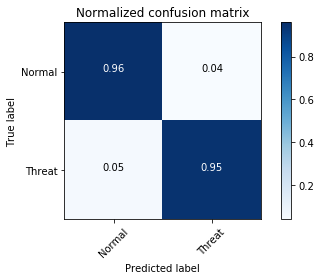

In [72]:
# Plot normalized confusion matrix
cm = confusion_matrix(y_eval, y_pred)
class_names = ['Normal','Threat']
plot_confusion_matrix(cm, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

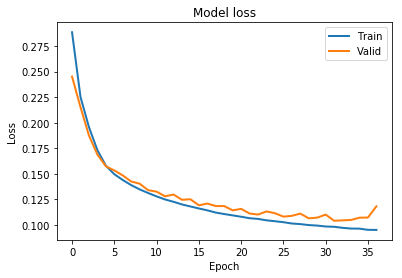

In [73]:
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

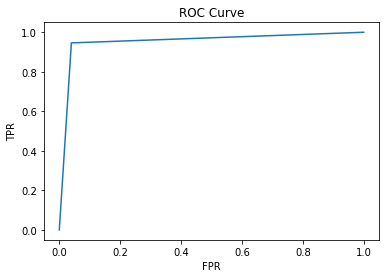

AUC: 0.9531914396228298


In [74]:
fpr, tpr, thresholds = metrics.roc_curve(y_eval, y_pred)

# Print ROC curve
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr,tpr)
plt.show() 


# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [76]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(x, y.argmax(1)):
  model = Sequential()
  model.add(Dense(54, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dense(y.shape[1],activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  history1 = model.fit(x[train],y[train],validation_data=(x[test],y[test]),callbacks=[monitor],verbose=2,epochs=1000)
  scores = model.evaluate(x[test], y[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
model.save("model2.h5")
print("Saved model to disk")


Train on 71987 samples, validate on 17998 samples
Epoch 1/1000
 - 6s - loss: 0.2824 - acc: 0.8828 - val_loss: 0.2347 - val_acc: 0.9015
Epoch 2/1000
 - 4s - loss: 0.2174 - acc: 0.9174 - val_loss: 0.1951 - val_acc: 0.9280
Epoch 3/1000
 - 4s - loss: 0.1864 - acc: 0.9344 - val_loss: 0.1737 - val_acc: 0.9392
Epoch 4/1000
 - 4s - loss: 0.1695 - acc: 0.9407 - val_loss: 0.1673 - val_acc: 0.9404
Epoch 5/1000
 - 4s - loss: 0.1592 - acc: 0.9442 - val_loss: 0.1533 - val_acc: 0.9453
Epoch 6/1000
 - 4s - loss: 0.1510 - acc: 0.9481 - val_loss: 0.1488 - val_acc: 0.9473
Epoch 7/1000
 - 4s - loss: 0.1458 - acc: 0.9501 - val_loss: 0.1429 - val_acc: 0.9500
Epoch 8/1000
 - 4s - loss: 0.1409 - acc: 0.9517 - val_loss: 0.1472 - val_acc: 0.9456
Epoch 9/1000
 - 4s - loss: 0.1378 - acc: 0.9528 - val_loss: 0.1382 - val_acc: 0.9501
Epoch 10/1000
 - 4s - loss: 0.1348 - acc: 0.9529 - val_loss: 0.1366 - val_acc: 0.9501
Epoch 11/1000
 - 4s - loss: 0.1321 - acc: 0.9535 - val_loss: 0.1341 - val_acc: 0.9523
Epoch 12/1000

Epoch 5/1000
 - 5s - loss: 0.1673 - acc: 0.9421 - val_loss: 0.1667 - val_acc: 0.9395
Epoch 6/1000
 - 5s - loss: 0.1572 - acc: 0.9465 - val_loss: 0.1588 - val_acc: 0.9495
Epoch 7/1000
 - 5s - loss: 0.1511 - acc: 0.9492 - val_loss: 0.1531 - val_acc: 0.9505
Epoch 8/1000
 - 5s - loss: 0.1464 - acc: 0.9510 - val_loss: 0.1555 - val_acc: 0.9534
Epoch 9/1000
 - 5s - loss: 0.1427 - acc: 0.9525 - val_loss: 0.1445 - val_acc: 0.9512
Epoch 10/1000
 - 5s - loss: 0.1390 - acc: 0.9531 - val_loss: 0.1428 - val_acc: 0.9512
Epoch 11/1000
 - 5s - loss: 0.1365 - acc: 0.9538 - val_loss: 0.1393 - val_acc: 0.9523
Epoch 12/1000
 - 5s - loss: 0.1340 - acc: 0.9544 - val_loss: 0.1356 - val_acc: 0.9534
Epoch 13/1000
 - 5s - loss: 0.1318 - acc: 0.9546 - val_loss: 0.1346 - val_acc: 0.9540
Epoch 14/1000
 - 5s - loss: 0.1293 - acc: 0.9551 - val_loss: 0.1338 - val_acc: 0.9562
Epoch 15/1000
 - 5s - loss: 0.1269 - acc: 0.9560 - val_loss: 0.1319 - val_acc: 0.9528
Epoch 16/1000
 - 5s - loss: 0.1250 - acc: 0.9563 - val_loss

Epoch 2/1000
 - 5s - loss: 0.2252 - acc: 0.9129 - val_loss: 0.2099 - val_acc: 0.9234
Epoch 3/1000
 - 5s - loss: 0.1985 - acc: 0.9245 - val_loss: 0.1878 - val_acc: 0.9315
Epoch 4/1000
 - 5s - loss: 0.1785 - acc: 0.9332 - val_loss: 0.1696 - val_acc: 0.9432
Epoch 5/1000
 - 5s - loss: 0.1631 - acc: 0.9426 - val_loss: 0.1582 - val_acc: 0.9467
Epoch 6/1000
 - 5s - loss: 0.1539 - acc: 0.9465 - val_loss: 0.1524 - val_acc: 0.9463
Epoch 7/1000
 - 5s - loss: 0.1469 - acc: 0.9499 - val_loss: 0.1441 - val_acc: 0.9512
Epoch 8/1000
 - 5s - loss: 0.1418 - acc: 0.9514 - val_loss: 0.1382 - val_acc: 0.9529
Epoch 9/1000
 - 5s - loss: 0.1380 - acc: 0.9528 - val_loss: 0.1365 - val_acc: 0.9533
Epoch 10/1000
 - 5s - loss: 0.1343 - acc: 0.9534 - val_loss: 0.1324 - val_acc: 0.9559
Epoch 11/1000
 - 5s - loss: 0.1311 - acc: 0.9547 - val_loss: 0.1299 - val_acc: 0.9557
Epoch 12/1000
 - 5s - loss: 0.1278 - acc: 0.9553 - val_loss: 0.1261 - val_acc: 0.9573
Epoch 13/1000
 - 5s - loss: 0.1255 - acc: 0.9562 - val_loss: 0

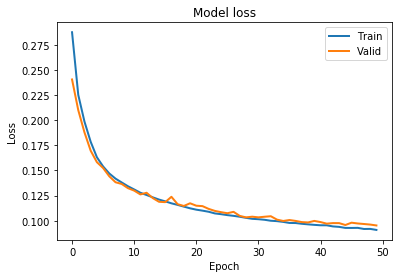

In [77]:
plt.plot(history1.history['loss'], linewidth=2, label='Train')
plt.plot(history1.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [78]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(x, y.argmax(1)):
  model = Sequential()
  model.add(Dense(54, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dense(y.shape[1],activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  history2 = model.fit(x[train],y[train],validation_data=(x[test],y[test]),callbacks=[monitor],verbose=0,epochs=1000)
  scores = model.evaluate(x[test], y[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
model.save("model3.h5")
print("Saved model to disk")


Epoch 00056: early stopping
acc: 96.06%
Epoch 00050: early stopping
acc: 96.30%
Epoch 00035: early stopping
acc: 96.09%
Epoch 00030: early stopping
acc: 95.81%
Epoch 00045: early stopping
acc: 96.27%
Epoch 00032: early stopping
acc: 96.33%
Epoch 00033: early stopping
acc: 96.01%
Epoch 00028: early stopping
acc: 96.55%
Epoch 00052: early stopping
acc: 96.58%
Epoch 00038: early stopping
acc: 96.69%
96.27% (+/- 0.27%)
Saved model to disk


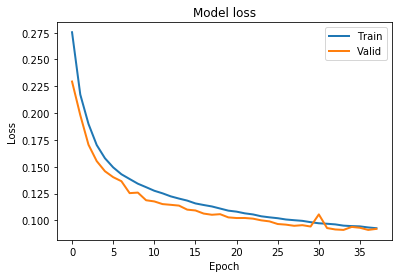

In [80]:
plt.plot(history2.history['loss'], linewidth=2, label='Train')
plt.plot(history2.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()